# Create and Test Models

In [18]:
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_csv("../data/scaled_final_data.csv")

X = df.drop(columns=["is_hit"])
y = df["is_hit"]

X = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_log))


Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.78      0.99      0.88       846
           1       0.17      0.00      0.01       235

    accuracy                           0.78      1081
   macro avg       0.47      0.50      0.44      1081
weighted avg       0.65      0.78      0.69      1081



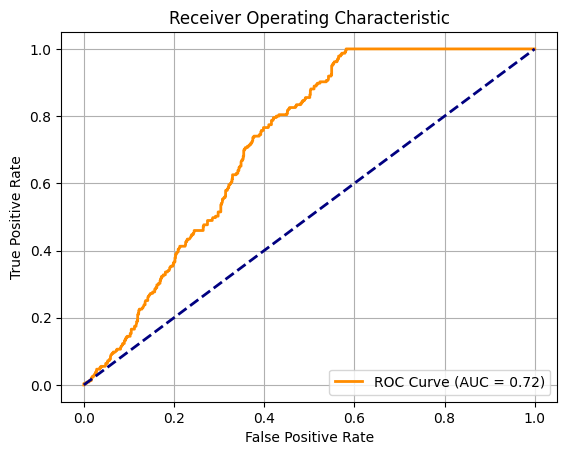

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()


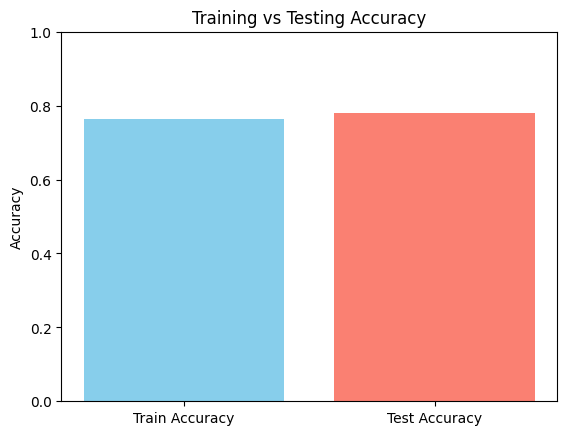

In [21]:
train_acc = log_reg.score(X_train, y_train)
test_acc = log_reg.score(X_test, y_test)

plt.bar(['Train Accuracy', 'Test Accuracy'], [train_acc, test_acc], color=['skyblue', 'salmon'])
plt.ylim(0, 1)
plt.title('Training vs Testing Accuracy')
plt.ylabel('Accuracy')
plt.show()


In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       846
           1       0.30      0.25      0.27       235

    accuracy                           0.71      1081
   macro avg       0.55      0.54      0.54      1081
weighted avg       0.69      0.71      0.70      1081



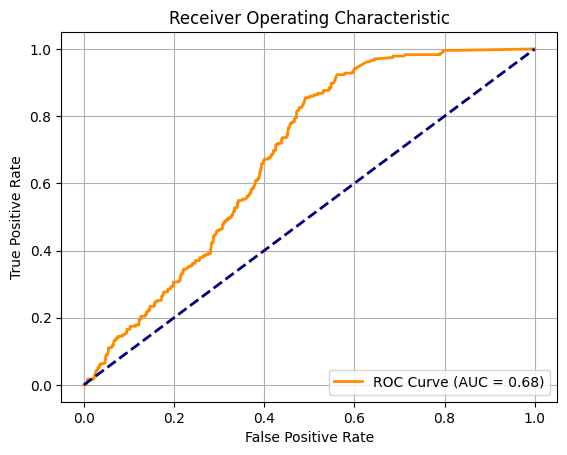

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# If your model supports predict_proba
y_prob = rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()


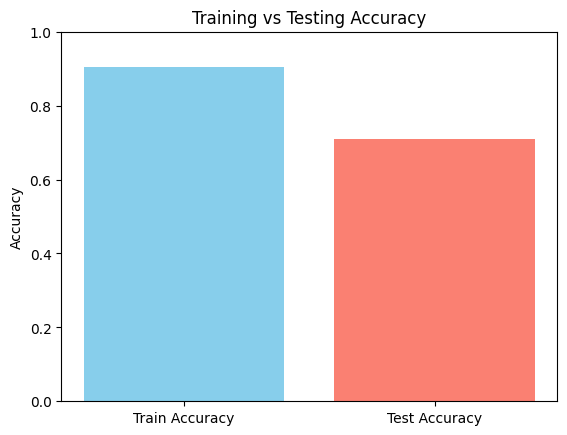

In [24]:
train_acc_rf = rf.score(X_train, y_train)
test_acc_rf = rf.score(X_test, y_test)

plt.bar(['Train Accuracy', 'Test Accuracy'], [train_acc_rf, test_acc_rf], color=['skyblue', 'salmon'])
plt.ylim(0, 1)
plt.title('Training vs Testing Accuracy')
plt.ylabel('Accuracy')
plt.show()

In [25]:
from sklearn.metrics import accuracy_score

log_accuracy = accuracy_score(y_test, y_pred_log)

print("Logistic Regression Accuracy:", log_accuracy)

rf_accuracy = accuracy_score(y_test, y_pred_rf)

print("Random Forest Accuracy:", rf_accuracy)

Logistic Regression Accuracy: 0.7789084181313598
Random Forest Accuracy: 0.7095282146160962


In [26]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Convert data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Create dataset and dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the model
class HitPredictor(nn.Module):
    def __init__(self, input_dim):
        super(HitPredictor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model = HitPredictor(input_dim=X_train.shape[1])
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
for epoch in range(epochs):
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluate
with torch.no_grad():
    preds = model(X_test_tensor).round()
    acc = (preds.eq(y_test_tensor)).float().mean()
    print(f"Neural Net Accuracy: {acc.item():.4f}")


Epoch 1/100, Loss: 0.4877
Epoch 2/100, Loss: 0.3633
Epoch 3/100, Loss: 0.5271
Epoch 4/100, Loss: 0.5087
Epoch 5/100, Loss: 0.4453
Epoch 6/100, Loss: 0.4253
Epoch 7/100, Loss: 0.4914
Epoch 8/100, Loss: 0.4521
Epoch 9/100, Loss: 0.4522
Epoch 10/100, Loss: 0.3315
Epoch 11/100, Loss: 0.6043
Epoch 12/100, Loss: 0.4169
Epoch 13/100, Loss: 0.4356
Epoch 14/100, Loss: 0.3375
Epoch 15/100, Loss: 0.5079
Epoch 16/100, Loss: 0.3148
Epoch 17/100, Loss: 0.2349
Epoch 18/100, Loss: 0.4441
Epoch 19/100, Loss: 0.4194
Epoch 20/100, Loss: 0.3801
Epoch 21/100, Loss: 0.3537
Epoch 22/100, Loss: 0.3630
Epoch 23/100, Loss: 0.4697
Epoch 24/100, Loss: 0.4000
Epoch 25/100, Loss: 0.3769
Epoch 26/100, Loss: 0.3757
Epoch 27/100, Loss: 0.3765
Epoch 28/100, Loss: 0.3160
Epoch 29/100, Loss: 0.4418
Epoch 30/100, Loss: 0.4012
Epoch 31/100, Loss: 0.3840
Epoch 32/100, Loss: 0.5568
Epoch 33/100, Loss: 0.3496
Epoch 34/100, Loss: 0.2548
Epoch 35/100, Loss: 0.3039
Epoch 36/100, Loss: 0.4018
Epoch 37/100, Loss: 0.5296
Epoch 38/1